Now we have the raw data produced. Below, we load the csv and print a few lines. We will have time numbers, the particular keypoints, for each person and the x and y coordinates. We will now process the interpersonal distance between the two persons ID0 and ID1 (which will correspond to the same persons if the two persons are in time for the entire video). 

In [1]:
import pandas as pd
import glob as glob

inputfollayer1 = '../data_fulldatatracked_afterSTEP1/'
# check if fps is correctly read in
videos = "../data_fulldata_raw/"

# check for a csv in the outputfolder using glob
layeronedat = glob.glob(inputfollayer1 + '*.csv')
print(layeronedat)
ts = pd.read_csv(layeronedat[0])
ts.head()


[]


IndexError: list index out of range

# Bounding boxes and social proximity

How would we generate the distance between persons of the above data structure? The first thing we need to do, is to compute single position that somehow summarizes the position of all keypoints of the individual. We could for example say, the position of the individual's body is the center of a bounding box, such that the bounding box just outlines the edges of the individual body segments. Or we could say, give me all the keypoint locations and compute the average x and y positions, such that we have the center of mass of the individual.

The below routine goes over each file again and now computes for each time a bounding box (all the maxima and minima of each dimensions based on the keypoints) and the centroid of that bounding box. We also generate a center of mass, which is the average location. We only do this for the upper body. So for each time.

We also add a time variable in seconds, which we base on the timerate which we check with each video.

## social distance measures (timeseries data)
- we also compute a smoothness measure between the distance measures
## Extra variables
We will also add some extra variables:
- midpoint between shoulder for person 1 and 2
- distance between shoulder midpoints (also a smoothed version)
- wrist positions
- left hand speed person 1 and 2 (also a smoothed version)
- right hand speed person 1 and 2 (also a smoothed version)

In [2]:
#!pip install --upgrade pandas

In [9]:
import pandas as pd
import numpy as np
import glob
import os
import cv2
import math
from bisect import bisect_left

inputfollayer1= '../data_fulldatatracked_afterSTEP1/'
outputfol = '../data_fulldatatotimeseries_afterSTEP2/'

def frame_to_time(ts, fps):
    """Convert frame numbers to time in seconds"""
    ts["time"] = [row[1]["frame"]/fps for row in ts.iterrows()]
    return ts

# PREPROCESSING
# No longer used, as the tracking code already limits each frame to detecting max 2 people
def identify_main_people(ts):
    """Identify the two most frequently tracked people and assign them as left/right"""
    # Count times per person
    person_counts = ts.groupby('person').size()
    
    # Get the two most frequent people
    main_people = person_counts.nlargest(2).index.tolist()
    
    # Calculate average x position for these two people
    avg_positions = ts[ts['person'].isin(main_people)].groupby('person')['x'].mean()
    
    # Assign left (0) and right (1) based on x position
    person_mapping = {}
    left_person = avg_positions.idxmin()
    right_person = avg_positions.idxmax()
    person_mapping[left_person] = 0  # Left person becomes person 0
    person_mapping[right_person] = 1  # Right person becomes person 1
    
    print(f"Original person IDs: Left = {left_person}, Right = {right_person}")
    
    # Create new Dataframe with remapped people
    ts_filtered = ts[ts['person'].isin(main_people)].copy()
    ts_filtered['person'] = ts_filtered['person'].map(person_mapping)
    
    return ts_filtered
    


def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def assign_left_right(ts):

    min_x = np.min([val for val in ts['x'] if val != 0 ])
    max_x = np.max([val for val in ts['x'] if val != 0 ])
    
    for index, row in ts.iterrows():
        if take_closest([min_x, max_x], row['x']) == min_x:
            ts.loc[index,'person'] = 0
        else:
            ts.loc[index,'person'] = 1
    
    return ts
    
# vectorized version of the above function
def process_people_data_vectorized(ts, stats):
    """Modified to preserve time alignment and fix COM/centroid assignment"""
    # Get all unique times from the original data
    all_times = sorted(ts['time'].unique())
    result = pd.DataFrame(index=all_times)
    result.index.name = 'time'
    
    # Process shoulders first
    shoulders = ts[ts['keypoint'].isin([5, 6])].groupby(['time', 'person']).agg({
        'x': 'mean',
        'y': 'mean'
    }).reset_index()
    
    # Process wrists
    wrists = ts[ts['keypoint'].isin([7, 8])].pivot_table(
        index=['time', 'person'],
        columns='keypoint',
        values=['x', 'y']
    ).reset_index()
    wrists.columns = ['time', 'person', 'left_x', 'right_x', 'left_y', 'right_y']
    
    # Get person-specific data
    p0_stats = stats[stats['person'] == 0].set_index('time')
    p1_stats = stats[stats['person'] == 1].set_index('time')
    
    # Process distances where both people exist
    common_times = sorted(set(p0_stats.index) & set(p1_stats.index))
    if common_times:  # Only calculate if we have common times
        result.loc[common_times, 'distance'] = np.sqrt(
            (p0_stats.loc[common_times, 'centroid_x'] - p1_stats.loc[common_times, 'centroid_x'])**2 + 
            (p0_stats.loc[common_times, 'centroid_y'] - p1_stats.loc[common_times, 'centroid_y'])**2
        )
        result.loc[common_times, 'distance_com'] = np.sqrt(
            (p0_stats.loc[common_times, 'com_x'] - p1_stats.loc[common_times, 'com_x'])**2 + 
            (p0_stats.loc[common_times, 'com_y'] - p1_stats.loc[common_times, 'com_y'])**2
        )
    
    # Process shoulders per person
    for person, prefix in [(0, 'p1'), (1, 'p2')]:
        s_person = shoulders[shoulders['person'] == person].set_index('time')
        result[f'shoulder_midpoint_{prefix}_x'] = s_person['x']
        result[f'shoulder_midpoint_{prefix}_y'] = s_person['y']
    
    # Calculate shoulder midpoint distance where possible
    shoulder_cols = ['shoulder_midpoint_p1_x', 'shoulder_midpoint_p2_x',
                    'shoulder_midpoint_p1_y', 'shoulder_midpoint_p2_y']
    shoulder_mask = result[shoulder_cols].notna().all(axis=1)
    if shoulder_mask.any():
        result.loc[shoulder_mask, 'distance_shoulder_midpoint'] = np.sqrt(
            (result.loc[shoulder_mask, 'shoulder_midpoint_p1_x'] - result.loc[shoulder_mask, 'shoulder_midpoint_p2_x'])**2 + 
            (result.loc[shoulder_mask, 'shoulder_midpoint_p1_y'] - result.loc[shoulder_mask, 'shoulder_midpoint_p2_y'])**2
        )
    
    # Process wrists per person and add COM/centroid
    for person, prefix in [(0, 'p1'), (1, 'p2')]:
        w_person = wrists[wrists['person'] == person].set_index('time')
        result[f'wrist_left_{prefix}_x'] = w_person['left_x']
        result[f'wrist_left_{prefix}_y'] = w_person['left_y']
        result[f'wrist_right_{prefix}_x'] = w_person['right_x']
        result[f'wrist_right_{prefix}_y'] = w_person['right_y']
        
        # FIX: Use the correct stats object based on person ID
        if person == 0:
            # For person 0, use p0_stats
            person_stats = p0_stats 
        else:
            # For person 1, use p1_stats
            person_stats = p1_stats
            
        # Add com and centroid with the correct stats object
        result[f'com_{prefix}_x'] = person_stats['com_x']
        result[f'com_{prefix}_y'] = person_stats['com_y']
        result[f'centroid_{prefix}_x'] = person_stats['centroid_x']
        result[f'centroid_{prefix}_y'] = person_stats['centroid_y']

    # Add tracking quality indicators using original data
    person_counts = ts.groupby('time')['person'].nunique()
    result['both_tracked'] = result.index.map(lambda x: person_counts.get(x, 0) == 2)
    result['single_tracked'] = result.index.map(lambda x: person_counts.get(x, 0) == 1)
        
    return result

# stats calculation
def process_time_data(ts):
    ts_upper = ts[ts['keypoint'] < 11]
    
    # Calculate stats for all tracked people without filtering
    stats = ts_upper.groupby(['time', 'person']).agg({
        'x': ['min', 'max', 'mean'],
        'y': ['min', 'max', 'mean']
    }).reset_index()
    
    stats.columns = ['time', 'person', 'x_min', 'x_max', 'com_x', 'y_min', 'y_max', 'com_y']
    stats['centroid_x'] = (stats['x_min'] + stats['x_max']) / 2
    stats['centroid_y'] = (stats['y_min'] + stats['y_max']) / 2
    
    return stats

In [10]:
import numpy as np
from scipy.signal import savgol_filter

# Calculate the position of com p1 and com p2, relative to a projected line between two shoulder midpoints
def calculate_proximity_approach(timeseries_data):
    """
    Calculate each person's position relative to their initial position,
    projecting movement onto the current connecting line between people.
    
    This handles rotation and changing spatial relationships between people.
    Positive values indicate movement toward the other person from initial position.
    
    The reference positions are only established when both people are detected.
    """
    # Create columns for our measurements
    if 'p1_com_approach_pos' not in timeseries_data.columns:
        timeseries_data['p1_com_approach_pos'] = np.nan
    if 'p2_com_approach_pos' not in timeseries_data.columns:
        timeseries_data['p2_com_approach_pos'] = np.nan
    
    # Sort data by time
    sorted_data = timeseries_data.sort_values('time')
    
    # Find first valid frame to establish reference positions
    reference_p1_pos = None
    reference_p2_pos = None
    reference_distance = None
    
    # First pass: find reference frame where both people are detected
    for idx, row in sorted_data.iterrows():
        # Skip rows with NaN values or where both_tracked is False
        if (np.isnan(row['com_p1_x']) or np.isnan(row['com_p1_y']) or 
            np.isnan(row['com_p2_x']) or np.isnan(row['com_p2_y']) or
            ('both_tracked' in row.index and row['both_tracked'] == False)):
            continue
            
        # Get positions for this frame
        p1_pos = np.array([row['com_p1_x'], row['com_p1_y']])
        p2_pos = np.array([row['com_p2_x'], row['com_p2_y']])
        
        # Calculate connecting vector
        connect_vector = p2_pos - p1_pos
        distance = np.linalg.norm(connect_vector)
        
        if distance > 0:
            # We found a valid reference frame
            reference_p1_pos = p1_pos.copy()
            reference_p2_pos = p2_pos.copy()
            reference_distance = distance
            print(f"Reference frame established at time={row['time']}")
            print(f"  Reference p1_pos: {reference_p1_pos}")
            print(f"  Reference p2_pos: {reference_p2_pos}")
            print(f"  Reference distance: {reference_distance}")
            break
    
    if reference_p1_pos is None:
        print("ERROR: Could not establish a reference frame. No valid frames found with both people detected.")
        return timeseries_data
    
    # Second pass: calculate projected positions for all frames
    for idx, row in sorted_data.iterrows():
        # Skip rows with NaN values
        if (np.isnan(row['com_p1_x']) or np.isnan(row['com_p1_y']) or 
            np.isnan(row['com_p2_x']) or np.isnan(row['com_p2_y'])):
            continue
            
        # Get current positions
        p1_pos = np.array([row['com_p1_x'], row['com_p1_y']])
        p2_pos = np.array([row['com_p2_x'], row['com_p2_y']])
        
        # Calculate current connecting vector and direction
        current_connect = p2_pos - p1_pos
        current_distance = np.linalg.norm(current_connect)
        
        # Skip frames where people are at the same position
        if current_distance == 0:
            continue
            
        current_direction = current_connect / current_distance
        
        # Calculate vector from reference position to current position
        p1_vector = p1_pos - reference_p1_pos
        p2_vector = p2_pos - reference_p2_pos
        
        # Project these vectors onto the current connecting line
        # Positive values mean moving toward the other person
        p1_projection = np.dot(p1_vector, current_direction)
        p2_projection = -np.dot(p2_vector, -current_direction)
        
        # Store values
        timeseries_data.loc[idx, 'p1_com_approach_pos'] = p1_projection
        timeseries_data.loc[idx, 'p2_com_approach_pos'] = p2_projection
    
    # Verify results
    filled_p1 = timeseries_data['p1_com_approach_pos'].notna().sum()
    filled_p2 = timeseries_data['p2_com_approach_pos'].notna().sum()
    
    print(f"Frames with filled values - p1: {filled_p1}, p2: {filled_p2}")
    
    return timeseries_data

# read the metadata TODO
#metadata = pd.read_csv('../data_sampledatatracked_afterSTEP1/metadata.csv')

# loop over the csv layer 1 data
for vids in layeronedat:
    # Load the CSV file
    ts = pd.read_csv(vids)
    #check fps video using opencv2
    vidname = os.path.basename(vids).split('_keypoints_data_layer1.csv')[0]
    print("Processing video: " + vidname)
    # lets check the sampling rate of the original video (its either avi or mp4)
    if os.path.exists(videos + '/' + vidname + '.avi'):
        video_path = videos + '/' + vidname + '.avi'
    elif os.path.exists(videos + '/' + vidname + '.mp4'):
        video_path = videos + '/' + vidname + '.mp4'
    elif os.path.exists(videos + '/' + vidname + '.mov'):
        video_path = videos + '/' + vidname + '.mov'
    else:
        print("Video file not found for " + vidname)
        continue
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    ts = frame_to_time(ts, fps=fps)
    print("working on the following data: " + vidname + " Assuming fps = " + str(fps))
    # check if already processed
    if os.path.exists(outputfol + '/' + vidname + '_processed_data_layer2.csv'):
        print("Already processed, skipping...")
        continue
    # filter the data to only include the two most tracked people
    #ts = identify_main_people(ts)
    ts = assign_left_right(ts)
    # Get valid stats only when both people are tracked
    stats = process_time_data(ts)
        
    # Lets set up a data frame with all the variables
    bb_data = pd.DataFrame(columns=['time', 'person', 'x_min', 'x_max', 'y_min', 'y_max', 'centroid_x', 'centroid_y', 'distance', 'distance_com', 
    'distance_shoulder_midpoint', 'shoulder_midpoint_p1_x', 'shoulder_midpoint_p2_x', 'shoulder_midpoint_p1_y', 'shoulder_midpoint_p2_y',
    'wrist_left_p1_x', 'wrist_left_p1_y', 'wrist_right_p1_x', 'wrist_right_p1_y', 'wrist_left_p2_x', 'wrist_left_p2_y', 'wrist_right_p2_x', 'wrist_right_p2_y', 
    'com_p1_x', 'com_p1_y', 'com_p2_x', 'com_p2_y', 'centroid_p1_x', 'centroid_p1_y', 'centroid_p2_x', 'centroid_p2_y', 'both_tracked', 'single_tracked','p1_com_approach_pos', 'p2_com_approach_pos'])
    
    # Fill time and person data
    for time in ts['time'].unique():
         bb_data.loc[2*time, ('time', 'person')] = [time, 0]
         bb_data.loc[2*time + 1, ('time', 'person')] = [time, 1]

    # VECTORIZED SECTION START
    # Filter upper body points once for all times
    ts_upper = ts[ts['keypoint'] < 11]

    # Process data directly using stats
    processed_data = process_people_data_vectorized(ts, stats)
    
    # Create final bb_data
    bb_data = pd.merge(
         stats, 
         processed_data.reset_index(), 
         on='time', 
         how='outer'
    )

    # Process time series data
    timeseries_data = bb_data[bb_data['person'] == 0] # person is not relevant here anymore so we can drop it
    
    # Interpolate NaN values
    nan_cols = timeseries_data.columns[timeseries_data.isna().any()].tolist()
    timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()
        # Add time variables
   # timeseries_data['time'] = timeseries_data['time'] * (1/fps) 
    # Remove unnecessary columns and add variables
    timeseries_data = timeseries_data.drop(columns='person')
    # Now make the time series uniform, as we have some missing person trackings in the data
    # Resample to uniform time steps (e.g., 0.02s)
    desired_time_step = 1/fps
    time_new = np.arange(timeseries_data['time'].min(), timeseries_data['time'].max(), desired_time_step)

    # Interpolate all columns over the new time grid
    #timeseries_data = timeseries_data.set_index('time').reindex(time_new).interpolate().reset_index() # this command makes every value, for each column, repeat after row 5 (ie a flat line for all columns)
    #timeseries_data.rename(columns={'index': 'time'}, inplace=True)
    #timeseries_data = timeseries_data.drop_duplicates(subset='time')  # Remove duplicates
    #timeseries_data = timeseries_data.sort_values('time')  # Ensure sorted order
    # TODO: we also need to save some information about interpolation to check what interpolation were actually doing
    
    # smooth the distance with savitsky golay filter
    timeseries_data['distance_smooth'] = savgol_filter(timeseries_data['distance'].values, 11, 3)
    
    # Apply savgol filter to all wrist speeds
    for wrist in ['wrist_left_p1', 'wrist_right_p1', 'wrist_left_p2', 'wrist_right_p2']:
          # Calculate speed as before
          timeseries_data[f'{wrist}_speed'] = (timeseries_data[f'{wrist}_x'].diff()**2 + 
                                                          timeseries_data[f'{wrist}_y'].diff()**2)**0.5
          
          # apply savgol filter
          timeseries_data[f'{wrist}_speed_smooth'] = savgol_filter(timeseries_data[f'{wrist}_speed'].values, 11, 3)
          
    # now compute the position of com p1 and com p2, relative to a projected line between two shoulder midpoints
    # Fill NaN values before inputting proximity
    timeseries_data = timeseries_data.fillna(method='ffill')
    timeseries_data = calculate_proximity_approach(timeseries_data)
    timeseries_data = timeseries_data.fillna(method='ffill')
    # now smooth the proximity with the same name
    timeseries_data['p1_com_approach_pos'] = savgol_filter(timeseries_data['p1_com_approach_pos'].values, 11, 3)
    timeseries_data['p2_com_approach_pos'] = savgol_filter(timeseries_data['p2_com_approach_pos'].values, 11, 3)
    # Fill NaN values with nearest non-NaN value
    timeseries_data = timeseries_data.fillna(method='ffill')
    # check for NaN values
    print("Checking for NaN values...")
    nan_counts = timeseries_data.isna().sum()
    if nan_counts.sum() > 0:
        print("Found NaN values after processing:")
        print(nan_counts)
    else:
        print("No NaN values found.")
    timeseries_data.to_csv(outputfol + '/' + vidname + '_processed_data_layer2.csv', index=False)
    # Check for missing time points
    print("Checking time continuity...")
    time_diffs = np.array([round(val,2) for val in np.diff(timeseries_data['time'])])
    if not np.all(time_diffs == desired_time_step):
        print(f"Found gaps at times: {np.where(time_diffs != desired_time_step)[0]}")
    else:
        print("No missing time points.")

Processing video: cop_p01
working on the following data: cop_p01 Assuming fps = 30.0
Already processed, skipping...
Processing video: cop_p02
working on the following data: cop_p02 Assuming fps = 30.0
Already processed, skipping...
Processing video: cop_p03
working on the following data: cop_p03 Assuming fps = 30.0
Already processed, skipping...
Processing video: cop_p04
working on the following data: cop_p04 Assuming fps = 30.0
Already processed, skipping...
Processing video: cop_p05
working on the following data: cop_p05 Assuming fps = 30.0
Already processed, skipping...
Processing video: cop_p06
working on the following data: cop_p06 Assuming fps = 30.0
Already processed, skipping...
Processing video: cop_p07
working on the following data: cop_p07 Assuming fps = 30.0
Already processed, skipping...
Processing video: cop_p08
working on the following data: cop_p08 Assuming fps = 30.0
Already processed, skipping...
Processing video: cop_p09
working on the following data: cop_p09 Assumin

D:\Programs\temp\ipykernel_187188\2850314257.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()


Reference frame established at time=0.0
  Reference p1_pos: [167.22775269 259.93494331]
  Reference p2_pos: [1296.43157959  448.94564056]
  Reference distance: 1144.9132396708421
Frames with filled values - p1: 4740, p2: 4740
Checking for NaN values...
Found NaN values after processing:
time                           0
x_min                          0
x_max                          0
com_x                          0
y_min                          0
y_max                          0
com_y                          0
centroid_x                     0
centroid_y                     0
distance                       0
distance_com                   0
shoulder_midpoint_p1_x         0
shoulder_midpoint_p1_y         0
shoulder_midpoint_p2_x         0
shoulder_midpoint_p2_y         0
distance_shoulder_midpoint     0
wrist_left_p1_x                0
wrist_left_p1_y                0
wrist_right_p1_x               0
wrist_right_p1_y               0
com_p1_x                       0
com_p1_y           

D:\Programs\temp\ipykernel_187188\2850314257.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()


Reference frame established at time=0.0
  Reference p1_pos: [154.78036165 284.10905457]
  Reference p2_pos: [1048.8678894   358.78498077]
  Reference distance: 897.2006471445736
Frames with filled values - p1: 4478, p2: 4478
Checking for NaN values...
Found NaN values after processing:
time                           0
x_min                          0
x_max                          0
com_x                          0
y_min                          0
y_max                          0
com_y                          0
centroid_x                     0
centroid_y                     0
distance                       0
distance_com                   0
shoulder_midpoint_p1_x         0
shoulder_midpoint_p1_y         0
shoulder_midpoint_p2_x         0
shoulder_midpoint_p2_y         0
distance_shoulder_midpoint     0
wrist_left_p1_x                0
wrist_left_p1_y                0
wrist_right_p1_x               0
wrist_right_p1_y               0
com_p1_x                       0
com_p1_y            

D:\Programs\temp\ipykernel_187188\2850314257.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()


Reference frame established at time=0.0
  Reference p1_pos: [93.2829365  88.44445801]
  Reference p2_pos: [1355.67753383  722.06893921]
  Reference distance: 1412.4872043857415
Frames with filled values - p1: 7134, p2: 7134
Checking for NaN values...
Found NaN values after processing:
time                           0
x_min                          0
x_max                          0
com_x                          0
y_min                          0
y_max                          0
com_y                          0
centroid_x                     0
centroid_y                     0
distance                       0
distance_com                   0
shoulder_midpoint_p1_x         0
shoulder_midpoint_p1_y         0
shoulder_midpoint_p2_x         0
shoulder_midpoint_p2_y         0
distance_shoulder_midpoint     0
wrist_left_p1_x                0
wrist_left_p1_y                0
wrist_right_p1_x               0
wrist_right_p1_y               0
com_p1_x                       0
com_p1_y             

D:\Programs\temp\ipykernel_187188\2850314257.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()


Reference frame established at time=0.0
  Reference p1_pos: [191.69288534 177.72042643]
  Reference p2_pos: [956.95302037 496.53533936]
  Reference distance: 829.0150921261716
Frames with filled values - p1: 6311, p2: 6311
Checking for NaN values...
Found NaN values after processing:
time                           0
x_min                          0
x_max                          0
com_x                          0
y_min                          0
y_max                          0
com_y                          0
centroid_x                     0
centroid_y                     0
distance                       0
distance_com                   0
shoulder_midpoint_p1_x         0
shoulder_midpoint_p1_y         0
shoulder_midpoint_p2_x         0
shoulder_midpoint_p2_y         0
distance_shoulder_midpoint     0
wrist_left_p1_x                0
wrist_left_p1_y                0
wrist_right_p1_x               0
wrist_right_p1_y               0
com_p1_x                       0
com_p1_y              

D:\Programs\temp\ipykernel_187188\2850314257.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()


Reference frame established at time=0.0
  Reference p1_pos: [207.18376967 124.22705796]
  Reference p2_pos: [1119.50952148  473.2420105 ]
  Reference distance: 976.8058735023208
Frames with filled values - p1: 5334, p2: 5334
Checking for NaN values...
Found NaN values after processing:
time                            0
x_min                           0
x_max                           0
com_x                           0
y_min                           0
y_max                           0
com_y                           0
centroid_x                      0
centroid_y                      0
distance                        0
distance_com                    0
shoulder_midpoint_p1_x          0
shoulder_midpoint_p1_y          0
shoulder_midpoint_p2_x          0
shoulder_midpoint_p2_y          0
distance_shoulder_midpoint      0
wrist_left_p1_x                 0
wrist_left_p1_y                 0
wrist_right_p1_x                0
wrist_right_p1_y                0
com_p1_x                        0

D:\Programs\temp\ipykernel_187188\2850314257.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()


Reference frame established at time=0.0
  Reference p1_pos: [36.67385864 29.51957703]
  Reference p2_pos: [1293.54270426  633.61837769]
  Reference distance: 1394.508750798071
Frames with filled values - p1: 7070, p2: 7070
Checking for NaN values...
Found NaN values after processing:
time                           0
x_min                          0
x_max                          0
com_x                          0
y_min                          0
y_max                          0
com_y                          0
centroid_x                     0
centroid_y                     0
distance                       0
distance_com                   0
shoulder_midpoint_p1_x         0
shoulder_midpoint_p1_y         0
shoulder_midpoint_p2_x         0
shoulder_midpoint_p2_y         0
distance_shoulder_midpoint     0
wrist_left_p1_x                0
wrist_left_p1_y                0
wrist_right_p1_x               0
wrist_right_p1_y               0
com_p1_x                       0
com_p1_y              

D:\Programs\temp\ipykernel_187188\2850314257.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()


Reference frame established at time=0.0
  Reference p1_pos: [248.1702301  264.38811849]
  Reference p2_pos: [1369.38928223  439.42374747]
  Reference distance: 1134.799380621506
Frames with filled values - p1: 6545, p2: 6545
Checking for NaN values...
Found NaN values after processing:
time                           0
x_min                          0
x_max                          0
com_x                          0
y_min                          0
y_max                          0
com_y                          0
centroid_x                     0
centroid_y                     0
distance                       0
distance_com                   0
shoulder_midpoint_p1_x         0
shoulder_midpoint_p1_y         0
shoulder_midpoint_p2_x         0
shoulder_midpoint_p2_y         0
distance_shoulder_midpoint     0
wrist_left_p1_x                0
wrist_left_p1_y                0
wrist_right_p1_x               0
wrist_right_p1_y               0
com_p1_x                       0
com_p1_y            

D:\Programs\temp\ipykernel_187188\2850314257.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()


Reference frame established at time=0.0
  Reference p1_pos: [283.65152384 226.13133748]
  Reference p2_pos: [1256.78873117  376.94590977]
  Reference distance: 984.7543142778968
Frames with filled values - p1: 7539, p2: 7539
Checking for NaN values...
Found NaN values after processing:
time                           0
x_min                          0
x_max                          0
com_x                          0
y_min                          0
y_max                          0
com_y                          0
centroid_x                     0
centroid_y                     0
distance                       0
distance_com                   0
shoulder_midpoint_p1_x         0
shoulder_midpoint_p1_y         0
shoulder_midpoint_p2_x         0
shoulder_midpoint_p2_y         0
distance_shoulder_midpoint     0
wrist_left_p1_x                0
wrist_left_p1_y                0
wrist_right_p1_x               0
wrist_right_p1_y               0
com_p1_x                       0
com_p1_y            

D:\Programs\temp\ipykernel_187188\2850314257.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()


Reference frame established at time=0.0
  Reference p1_pos: [161.11034966 266.85855675]
  Reference p2_pos: [1525.89809163  628.07873027]
  Reference distance: 1411.781000868163
Frames with filled values - p1: 6910, p2: 6910
Checking for NaN values...
Found NaN values after processing:
time                           0
x_min                          0
x_max                          0
com_x                          0
y_min                          0
y_max                          0
com_y                          0
centroid_x                     0
centroid_y                     0
distance                       0
distance_com                   0
shoulder_midpoint_p1_x         0
shoulder_midpoint_p1_y         0
shoulder_midpoint_p2_x         0
shoulder_midpoint_p2_y         0
distance_shoulder_midpoint     0
wrist_left_p1_x                0
wrist_left_p1_y                0
wrist_right_p1_x               0
wrist_right_p1_y               0
com_p1_x                       0
com_p1_y            

D:\Programs\temp\ipykernel_187188\2850314257.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()


Reference frame established at time=0.0
  Reference p1_pos: [171.45503743 140.02356635]
  Reference p2_pos: [1393.20678711  504.5134201 ]
  Reference distance: 1274.9628195839764
Frames with filled values - p1: 3030, p2: 3030
Checking for NaN values...
Found NaN values after processing:
time                           0
x_min                          0
x_max                          0
com_x                          0
y_min                          0
y_max                          0
com_y                          0
centroid_x                     0
centroid_y                     0
distance                       0
distance_com                   0
shoulder_midpoint_p1_x         0
shoulder_midpoint_p1_y         0
shoulder_midpoint_p2_x         3
shoulder_midpoint_p2_y         3
distance_shoulder_midpoint     3
wrist_left_p1_x                0
wrist_left_p1_y                0
wrist_right_p1_x               0
wrist_right_p1_y               0
com_p1_x                       0
com_p1_y           

In [5]:
# Print final columns
print(len(timeseries_data))
timeseries_data = pd.read_csv(outputfol + '/' + vidname + '_processed_data_layer2.csv')
print('variables we have saved are the following: ', timeseries_data.columns)    
timeseries_data.head()

43059
variables we have saved are the following:  Index(['time', 'x_min', 'x_max', 'com_x', 'y_min', 'y_max', 'com_y',
       'centroid_x', 'centroid_y', 'distance', 'distance_com',
       'shoulder_midpoint_p1_x', 'shoulder_midpoint_p1_y',
       'shoulder_midpoint_p2_x', 'shoulder_midpoint_p2_y',
       'distance_shoulder_midpoint', 'wrist_left_p1_x', 'wrist_left_p1_y',
       'wrist_right_p1_x', 'wrist_right_p1_y', 'com_p1_x', 'com_p1_y',
       'centroid_p1_x', 'centroid_p1_y', 'wrist_left_p2_x', 'wrist_left_p2_y',
       'wrist_right_p2_x', 'wrist_right_p2_y', 'com_p2_x', 'com_p2_y',
       'centroid_p2_x', 'centroid_p2_y', 'both_tracked', 'single_tracked',
       'distance_smooth', 'wrist_left_p1_speed', 'wrist_left_p1_speed_smooth',
       'wrist_right_p1_speed', 'wrist_right_p1_speed_smooth',
       'wrist_left_p2_speed', 'wrist_left_p2_speed_smooth',
       'wrist_right_p2_speed', 'wrist_right_p2_speed_smooth',
       'p1_com_approach_pos', 'p2_com_approach_pos'],
      dtype=

,time,x_min,x_max,com_x,y_min,y_max,com_y,centroid_x,centroid_y,distance,...,wrist_left_p1_speed,wrist_left_p1_speed_smooth,wrist_right_p1_speed,wrist_right_p1_speed_smooth,wrist_left_p2_speed,wrist_left_p2_speed_smooth,wrist_right_p2_speed,wrist_right_p2_speed_smooth,p1_com_approach_pos,p2_com_approach_pos
0,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plotting and animating
Below we set up a plotting function that we will use for our animations.

Time range: 0.0 to 127.53333333333332 seconds


D:\Programs\temp\ipykernel_187188\3075883834.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


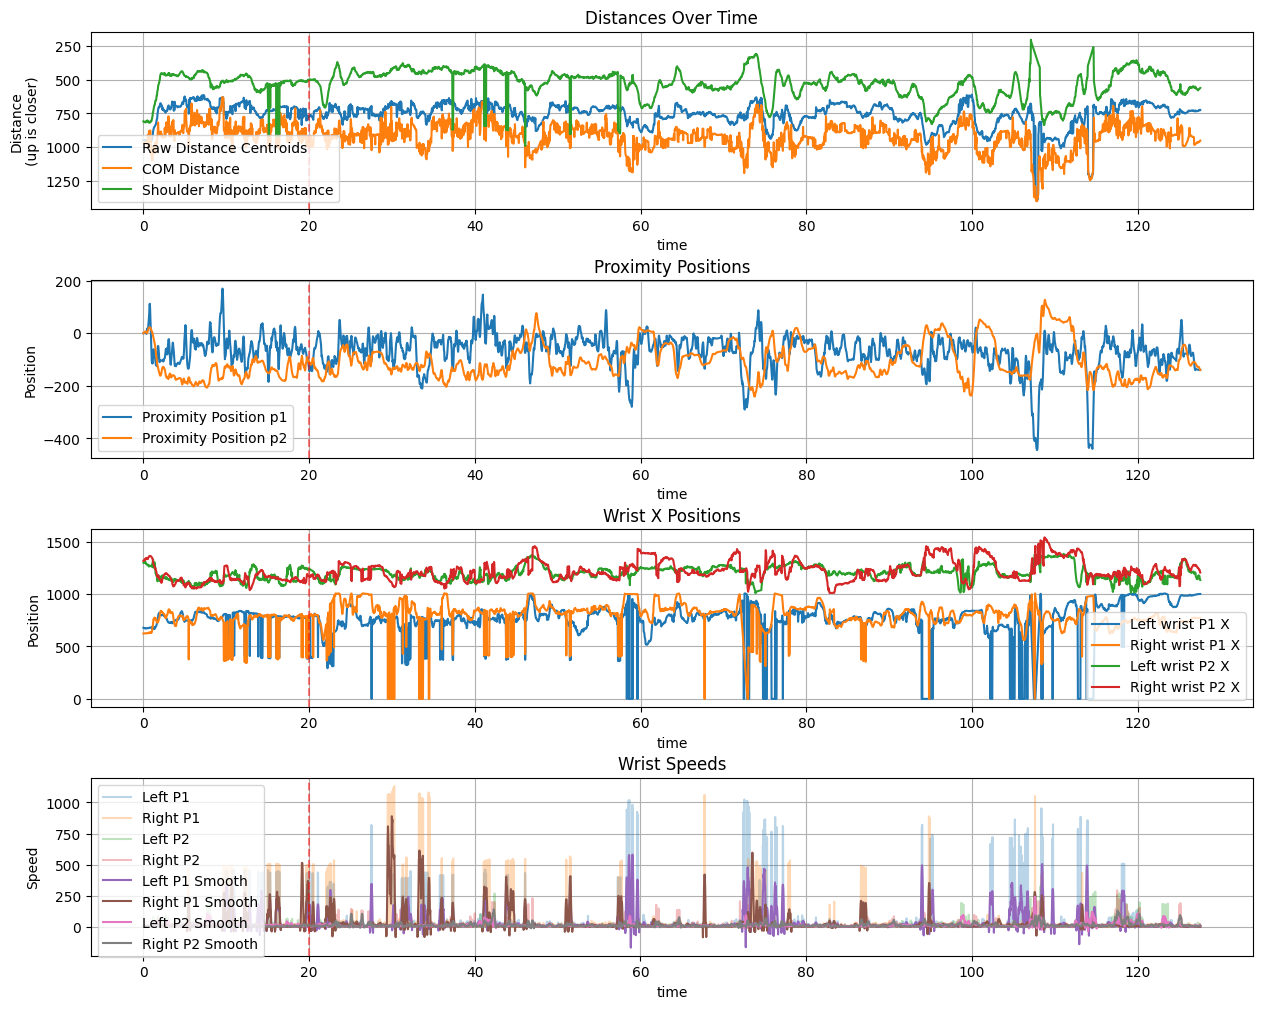

In [6]:
# plot the distance
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import cv2
import pandas as pd
import numpy as np
import glob as glob

# Load a sample CSV file with distance data using glob'
outputfol = '../data_fulldatatotimeseries_afterSTEP2/'
vidname = glob.glob(outputfol + '*.csv')[0].split('/')[-1].split('_processed_data_layer2.csv')[0]
timeseries_data = pd.read_csv('../'+vidname + '_processed_data_layer2.csv')
# print time range and steps
print(f"Time range: {timeseries_data['time'].min()} to {timeseries_data['time'].max()} seconds")

# make a function out of this
def plot_timeseries(timeseries_data, current_time=None, figsize=(15, 12)):
     """
     Create a comprehensive visualization of motion analysis data.
     
     Parameters:
     -----------
     timeseries_data : pandas.DataFrame
          DataFrame containing all the motion analysis columns
     current_time : int, optional
          time number to mark with vertical line
     figsize : tuple, optional
          Figure size in inches (width, height)
     """
     # Create figure with subplots
     fig = plt.figure(figsize=figsize)
     
     # Define grid layout
     gs = plt.GridSpec(4, 1, height_ratios=[1, 1, 1, 1], hspace=0.4)
     
     # 1. Distance Plots
     ax1 = fig.add_subplot(gs[0])
     sns.lineplot(data=timeseries_data, x='time', y='distance', label='Raw Distance Centroids', ax=ax1)
     sns.lineplot(data=timeseries_data, x='time', y='distance_com', label='COM Distance', ax=ax1)
     sns.lineplot(data=timeseries_data, x='time', y='distance_shoulder_midpoint', label='Shoulder Midpoint Distance', ax=ax1)
     ax1.set_title('Distances Over Time')
     ax1.set_ylabel('Distance\n(up is closer)')
     ax1.grid(True)
     ax1.invert_yaxis()
     
     # 2. p1_com_approach_pos', 'p2_com_approach_pos
     ax2 = fig.add_subplot(gs[1])
     sns.lineplot(data=timeseries_data, x='time', y='p1_com_approach_pos', label='Proximity Position p1', ax=ax2)
     sns.lineplot(data=timeseries_data, x='time', y='p2_com_approach_pos', label='Proximity Position p2', ax=ax2)
     ax2.set_title('Proximity Positions')
     ax2.set_ylabel('Position')
     ax2.grid(True)
     
     # 3. Wrist Positions
     ax3 = fig.add_subplot(gs[2])
     sns.lineplot(data=timeseries_data, x='time', y='wrist_left_p1_x', label='Left wrist P1 X', ax=ax3)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_right_p1_x', label='Right wrist P1 X', ax=ax3)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_left_p2_x', label='Left wrist P2 X', ax=ax3)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_right_p2_x', label='Right wrist P2 X', ax=ax3)
     ax3.set_title('Wrist X Positions')
     ax3.set_ylabel('Position')
     ax3.grid(True)
     
     # 4. Wrist Speeds
     ax4 = fig.add_subplot(gs[3])
     # Raw speeds
     sns.lineplot(data=timeseries_data, x='time', y='wrist_left_p1_speed', label='Left P1', alpha=0.3, ax=ax4)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_right_p1_speed', label='Right P1', alpha=0.3, ax=ax4)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_left_p2_speed', label='Left P2', alpha=0.3, ax=ax4)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_right_p2_speed', label='Right P2', alpha=0.3, ax=ax4)
     # Smoothed speeds
     sns.lineplot(data=timeseries_data, x='time', y='wrist_left_p1_speed_smooth', label='Left P1 Smooth', ax=ax4)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_right_p1_speed_smooth', label='Right P1 Smooth', ax=ax4)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_left_p2_speed_smooth', label='Left P2 Smooth', ax=ax4)
     sns.lineplot(data=timeseries_data, x='time', y='wrist_right_p2_speed_smooth', label='Right P2 Smooth', ax=ax4)
     ax4.set_title('Wrist Speeds')
     ax4.set_ylabel('Speed')
     ax4.grid(True)
     
     # Add vertical line for current time if specified
     if current_time is not None:
          for ax in [ax1, ax2, ax3, ax4]:
                ax.axvline(x=current_time, color='r', linestyle='--', alpha=0.5)
     
     # Set common x-label
     plt.xlabel('time')
     
     # Adjust layout
     plt.tight_layout()
     
     return fig


test = plot_timeseries(timeseries_data, 20)

# save the plot
plofol = '../plots/'
test.savefig(plofol + 'checkplot.png')


We are now going to generate flat datasets for each trial. Such that we get a smoothness values for each trial.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
from scipy import integrate
from scipy import interpolate
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import os
import glob

# specifically we might be interested in computing the smoothness of the distance
inputfol = '../data_timeseries_afterSTEP2/'
outputfol = '../data_afterSTEP3/'
metadata = pd.read_csv('../meta/project_pointsibling_metadata_starttimes.csv', encoding='latin1')
constantwindowsize_sec = 100 # we want an equal portion of each timeseries to be analyzed

import numpy as np

def spectral_arclength(movement, fs, padlevel=4, fc=10.0, amp_th=0.05):
    """
    Calcualtes the smoothness of the given speed profile using the modified spectral
    arc length metric.

    Parameters
    ----------
    movement : np.array
               The array containing the movement speed profile.
    fs       : float
               The sampling frequency of the data.
    padlevel : integer, optional
               Indicates the amount of zero padding to be done to the movement
               data for estimating the spectral arc length. [default = 4]
    fc       : float, optional
               The max. cut off frequency for calculating the spectral arc
               length metric. [default = 10.]
    amp_th   : float, optional
               The amplitude threshold to used for determing the cut off
               frequency upto which the spectral arc length is to be estimated.
               [default = 0.05]

    Returns
    -------
    sal      : float
               The spectral arc length estimate of the given movement's
               smoothness.
    (f, Mf)  : tuple of two np.arrays
               This is the frequency(f) and the magntiude spectrum(Mf) of the
               given movement data. This spectral is from 0. to fs/2.
    (f_sel, Mf_sel) : tuple of two np.arrays
                      This is the portion of the spectrum that is selected for
                      calculating the spectral arc length.

    Notes
    -----
    This is the modfieid spectral arc length metric, which has been tested only
    for discrete movements.
    It is suitable for movements that are a few seconds long, but for long
    movements it might be slow and results might not make sense (like any other
    smoothness metric).

    Examples
    --------
    >>> t = np.arange(-1, 1, 0.01)
    >>> move = np.exp(-5*pow(t, 2))
    >>> sal, _, _ = spectral_arclength(move, fs=100.)
    >>> '%.5f' % sal
    '-1.41403'

    """
    # Number of zeros to be padded.
    nfft = int(pow(2, np.ceil(np.log2(len(movement))) + padlevel))

    # Frequency
    f = np.arange(0, fs, fs/nfft)
    # Normalized magnitude spectrum
    Mf = abs(np.fft.fft(movement, nfft))
    Mf = Mf/max(Mf)

    # Indices to choose only the spectrum within the given cut off frequency Fc.
    # NOTE: This is a low pass filtering operation to get rid of high frequency
    # noise from affecting the next step (amplitude threshold based cut off for
    # arc length calculation).
    fc_inx = ((f <= fc)*1).nonzero()
    f_sel = f[fc_inx]
    Mf_sel = Mf[fc_inx]

    # Choose the amplitude threshold based cut off frequency.
    # Index of the last point on the magnitude spectrum that is greater than
    # or equal to the amplitude threshold.
    inx = ((Mf_sel >= amp_th)*1).nonzero()[0]
    fc_inx = range(inx[0], inx[-1]+1)
    f_sel = f_sel[fc_inx]
    Mf_sel = Mf_sel[fc_inx]

    # Calculate arc length
    new_sal = -sum(np.sqrt(pow(np.diff(f_sel)/(f_sel[-1] - f_sel[0]), 2) +
                           pow(np.diff(Mf_sel), 2)))
    return new_sal, (f, Mf), (f_sel, Mf_sel)

def dimensionless_squared_jerk_from_position(ts, time):
    """
    Calculate the dimensionless squared jerk metric from position data.
    
    Parameters:
    -----------
    ts : array_like
        Position data points, should be a 1D numpy array
    time : array_like
        Time points corresponding to the ts data, should be a 1D numpy array
    
    Returns:
    --------
    float
        Dimensionless squared jerk metric or NaN if calculation fails
    """
    try:
        # First check the raw inputs
        ts = np.array(ts, dtype=float)
        time = np.array(time, dtype=float)
        
        print(f"Original shape - ts: {ts.shape}, time: {time.shape}")
        print(f"NaN count before processing - ts: {np.isnan(ts).sum()}, time: {np.isnan(time).sum()}")
        
        # Input validation before preprocessing
        if len(ts) != len(time):
            print(f"Error: Arrays must have the same length. ts: {len(ts)}, time: {len(time)}")
            return np.nan
            
        if len(ts) < 11:  # Minimum length for savgol filter
            print(f"Error: Input arrays too short for savgol window size=11. Length: {len(ts)}")
            return np.nan
        
        # Check if time has NaNs - we need to fix time first
        if np.isnan(time).any():
            print("Warning: Time array contains NaNs, filling with linear sequence")
            valid_time_mask = ~np.isnan(time)
            if not valid_time_mask.any():
                print("Error: All time values are NaN")
                return np.nan
                
            # Create a proper time sequence
            time = np.linspace(np.nanmin(time), np.nanmax(time), len(time))
        
        # Check if input data is all NaN
        if np.isnan(ts).all():
            print("Error: All input values are NaN")
            return np.nan
        
        # Identify valid data points for interpolation
        valid_mask = ~np.isnan(ts)
        valid_indices = np.where(valid_mask)[0]
        
        if len(valid_indices) < 2:
            print(f"Error: Not enough valid data points for interpolation. Found {len(valid_indices)}")
            return np.nan
        
        # Handle the interpolation more carefully
        # 1. Use valid points to interpolate
        if np.isnan(ts).any():
            try:               
                # Create interpolator with valid points only
                valid_time = time[valid_mask]
                valid_data = ts[valid_mask]
                
                # Sort by time to ensure proper interpolation
                sort_idx = np.argsort(valid_time)
                valid_time = valid_time[sort_idx]
                valid_data = valid_data[sort_idx]
                
                # Create interpolation function
                f = interpolate.interp1d(
                    valid_time, valid_data,
                    bounds_error=False,
                    fill_value=(valid_data[0], valid_data[-1])  # Extrapolate with edge values
                )
                
                # Apply interpolation
                ts_interpolated = f(time)
                
                # Check if interpolation fixed all NaNs
                if np.isnan(ts_interpolated).any():
                    print(f"Warning: Interpolation failed to fix all NaNs. Remaining: {np.isnan(ts_interpolated).sum()}")
                    # Last resort: replace any remaining NaNs with nearest valid value
                    ts_interpolated = pd.Series(ts_interpolated).fillna(method='ffill').fillna(method='bfill').values
                
                ts = ts_interpolated
            except Exception as e:
                print(f"Error during interpolation: {str(e)}")
                return np.nan
        
        # Verify no NaNs remain after preprocessing
        if np.isnan(ts).any() or np.isnan(time).any():
            print("Error: Failed to remove all NaN values")
            return np.nan
            
        # Ensure time steps are uniform for derivative calculation
        uniform_time = np.linspace(time[0], time[-1], len(time))
        if not np.allclose(time, uniform_time):
            # If time is not uniform, resample the data
            print("Warning: Time steps not uniform, resampling data")
            # Use scipy's interpolation again to resample
            f = interpolate.interp1d(time, ts, bounds_error=False, fill_value='extrapolate')
            ts = f(uniform_time)
            time = uniform_time
        
        # Calculate the time step
        dt = np.diff(time)[0]
        
        if dt <= 0:
            print(f"Error: Time steps must be positive. Got dt={dt}")
            return np.nan
        
        # Print state after preprocessing
        print(f"Data after preprocessing - Length: {len(ts)}")
        print(f"NaN check after preprocessing - ts: {np.isnan(ts).any()}, time: {np.isnan(time).any()}")
        print(f"Range - ts: {np.min(ts)} to {np.max(ts)}, time: {np.min(time)} to {np.max(time)}")
        
        # Calculate speed (exactly as in original)
        speed = np.gradient(ts, dt)

        # Smooth savgol filter (maintaining original settings)
        speed = savgol_filter(speed, 11, 3)

        # Calculate acceleration (exactly as in original)
        acceleration = np.gradient(speed, dt)

        # Smooth (maintaining original settings)
        acceleration = savgol_filter(acceleration, 11, 3)
        
        # Calculate jerk (exactly as in original)
        jerk = np.gradient(acceleration, dt)
        
        # Smooth (maintaining original settings)
        jerk = savgol_filter(jerk, 11, 3)
        
        # Calculate movement duration (D)
        movement_duration = time[-1] - time[0]
        
        if movement_duration <= 0:
            print(f"Error: Movement duration must be positive. Got {movement_duration}")
            return np.nan
        
        # Calculate movement amplitude by integrating speed
        position = integrate.simpson(speed, x=time)
        movement_amplitude = abs(position)  # Use absolute value to ensure positive
        
        # Prevent division by zero
        epsilon = 1e-10
        if movement_amplitude < epsilon:
            print(f"Warning: Movement amplitude very small ({movement_amplitude}). Using epsilon.")
            movement_amplitude = epsilon
            
        # Calculate the squared jerk
        squared_jerk = jerk ** 2
        
        # Integrate the squared jerk
        integrated_squared_jerk = integrate.simpson(squared_jerk, x=time)
        
        # Ensure positive value for integral of squared jerk
        if integrated_squared_jerk < 0:
            print(f"Warning: Negative integral of squared jerk: {integrated_squared_jerk}. Using absolute value.")
            integrated_squared_jerk = abs(integrated_squared_jerk)
        
        # Calculate the dimensionless squared jerk
        dimensionless_jerk = integrated_squared_jerk * (movement_duration**5 / movement_amplitude**2)
        
        # Final sanity check
        if np.isnan(dimensionless_jerk) or np.isinf(dimensionless_jerk):
            print(f"Warning: Result is {dimensionless_jerk}. Details: ")
            print(f"  Movement duration: {movement_duration}")
            print(f"  Movement amplitude: {movement_amplitude}")
            print(f"  Integrated squared jerk: {integrated_squared_jerk}")
            return np.nan
        # log the result
        
        print(f"Dimensionless squared jerk: {dimensionless_jerk}")
        # log the dimensionless jerk
        dimensionless_jerk = np.log(dimensionless_jerk)

        return dimensionless_jerk
        
    except Exception as e:
        print(f"Error calculating dimensionless squared jerk: {str(e)}")
        return np.nan
    
# df for smoothness date
newdfcolumns = ['videoID','timeadjusted', 'originalsamples','adjustedsamples', 'start_time_analysiswindow', 'end_time_analysiswindow', 'perc_twopersonsdetected', 'average_com_movementp1', 'average_com_movementp2', 'smoothness_distancecom', 'SPARC_smoothness_distancecom', 'smoothness_distancecentroid', 'smoothness_xy_average_com_p1', 'smoothness_xy_average_com_p2', 'smoothness_xy_average_centroid_p1', 'smoothness_xy_average_centroid_p2', 'smoothness_p1_proximity', 'smoothness_p2_proximity']
newdf = pd.DataFrame(columns=newdfcolumns)

# check for each csv file for layer2 data
layer2dat = glob.glob(inputfol + '*.csv')
#print(layer2dat)

# loop over the csv layer 2 data
for vids in layer2dat:
     print(vids)
     # Load the CSV timeseries file
     ts = pd.read_csv(vids)
     # get the features
     videoID = os.path.basename(vids).split('_processed_data_layer2.csv')[0]
     originalsamples = len(ts["time"])
     perc_twopersonsdetected = ts['both_tracked'].sum() / len(ts)
     # check metadata start
     start = metadata[metadata['VIDEO_ID'] == videoID]['start'].values
     print("start time of this video: " + str(start))
     # calculate the average movement of the com for each person
     average_com_movementp1 = np.mean(np.sqrt((ts['com_p1_x'].diff()**2 + ts['com_p1_y'].diff()**2)))
     average_com_movementp2 = np.mean(np.sqrt((ts['com_p2_x'].diff()**2 + ts['com_p2_y'].diff()**2)))
     # add a time adjusted variable to the dataset
     if start.size > 0: 
        # check if endtime not greater than the last time in the dataset
        if (start[0] + constantwindowsize_sec) > ts['time'].max():
            print("End time is greater than the last time in the dataset, setting end time to max value")
        timeadjusted = "TRUE - Adjusted to start at + " + str(start[0]) + "With a window length of: " + str(constantwindowsize_sec) + " seconds"
        # Take a timeseries chunk of 150 seconds
        ts = ts[(ts['time'] >= start[0]) & (ts['time'] <= start[0] + constantwindowsize_sec)]
     if start.size == 0:
        timeadjusted = "FALSE - Not adjusted to start time as no start time was given for this video, window length is still set to: " + str(constantwindowsize_sec) + " seconds"
        ts = ts[(ts['time'] <= constantwindowsize_sec)]
     adjustedsamples = len(ts["time"])
     print(timeadjusted) 
     # fps is mode timestaps per second 
     fps = 1/(ts['time'].diff().mode()[0])
     # add time start and time end
     start_time_analysiswindow = start[0] if start.size > 0 else 0
     end_time_analysiswindow = start_time_analysiswindow + constantwindowsize_sec
     # calculate the smoothness of the distance between the com and centroid
     smoothness_distancecom = dimensionless_squared_jerk_from_position(ts['distance_com'].values, ts['time'].values)
     # take the derivative of the distance
     distancecomspeed = np.gradient(ts['distance_com'].values, ts['time'].values)
     SPARCsmoothness_distancecom = spectral_arclength(distancecomspeed, 1/fps, padlevel=4, fc=10.0, amp_th=0.05)
     #print(smoothness_distancecom)
     smoothness_distancecentroid = dimensionless_squared_jerk_from_position(ts['distance'].values, ts['time'].values)
     # calculate the smoothness of the xy positions for each person
     smoothness_xy_average_com_p1 = (dimensionless_squared_jerk_from_position(ts['com_p1_x'],ts['time'].values)+dimensionless_squared_jerk_from_position(ts['com_p1_y'],ts['time'].values))/2
     smoothness_xy_average_com_p2 = (dimensionless_squared_jerk_from_position(ts['com_p2_x'],ts['time'].values)+dimensionless_squared_jerk_from_position(ts['com_p2_y'],ts['time'].values))/2
     smoothness_xy_average_centroid_p1 = (dimensionless_squared_jerk_from_position(ts['centroid_p1_x'],ts['time'].values)+dimensionless_squared_jerk_from_position(ts['centroid_p1_y'],ts['time'].values))/2
     smoothness_xy_average_centroid_p2 = (dimensionless_squared_jerk_from_position(ts['centroid_p2_x'],ts['time'].values)+dimensionless_squared_jerk_from_position(ts['centroid_p2_y'],ts['time'].values))/2
     # calculate the smoothness of the proximity approach
     smoothness_p1_proximity = dimensionless_squared_jerk_from_position(ts['p1_com_approach_pos'].values, ts['time'].values)
     smoothness_p2_proximity = dimensionless_squared_jerk_from_position(ts['p2_com_approach_pos'].values, ts['time'].values)
     # append to the new df using concat
     newdf = pd.concat([newdf, pd.DataFrame([[videoID, timeadjusted, originalsamples, adjustedsamples, start_time_analysiswindow, end_time_analysiswindow, perc_twopersonsdetected, average_com_movementp1, average_com_movementp2, smoothness_distancecom, SPARCsmoothness_distancecom, smoothness_distancecentroid, smoothness_xy_average_com_p1, smoothness_xy_average_com_p2, smoothness_xy_average_centroid_p1, smoothness_xy_average_centroid_p2, smoothness_p1_proximity, smoothness_p2_proximity]], columns=newdfcolumns)], ignore_index=True)

# save the new df
newdf.to_csv(outputfol + 'smoothness_data.csv', index=False, encoding='latin1')
newdf.head()
# print done
print("Done with smoothness processing pipeline!")


../data_fulldatatotimeseries_afterSTEP2\cop_p01_processed_data_layer2.csv
start time of this video: []


InvalidIndexError: (slice(None, None, None), 1)

In the following chunk, we loop over each time of the tracked video, and then we generate a figure with the vertical bar at the precise time number, and plot the timeseries plot onto the video (in the lower region). In this way we can show the changing social proximity.

  0%|          | 0/17524 [00:00<?, ?it/s]D:\Programs\temp\ipykernel_37364\3589839606.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
  0%|          | 1/17524 [00:01<8:19:24,  1.71s/it]D:\Programs\temp\ipykernel_37364\3589839606.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
  0%|          | 2/17524 [00:03<7:47:49,  1.60s/it]D:\Programs\temp\ipykernel_37364\3589839606.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
  0%|          | 3/17524 [00:04<7:36:04,  1.56s/it]D:\Programs\temp\ipykernel_37364\3589839606.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
  0%|          | 4/17524 [00:06<7:28:47,  1.54s/it]D:\Programs\tem

KeyboardInterrupt: 

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


Error in callback <function _draw_all_if_interactive at 0x000001AD217FBE20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


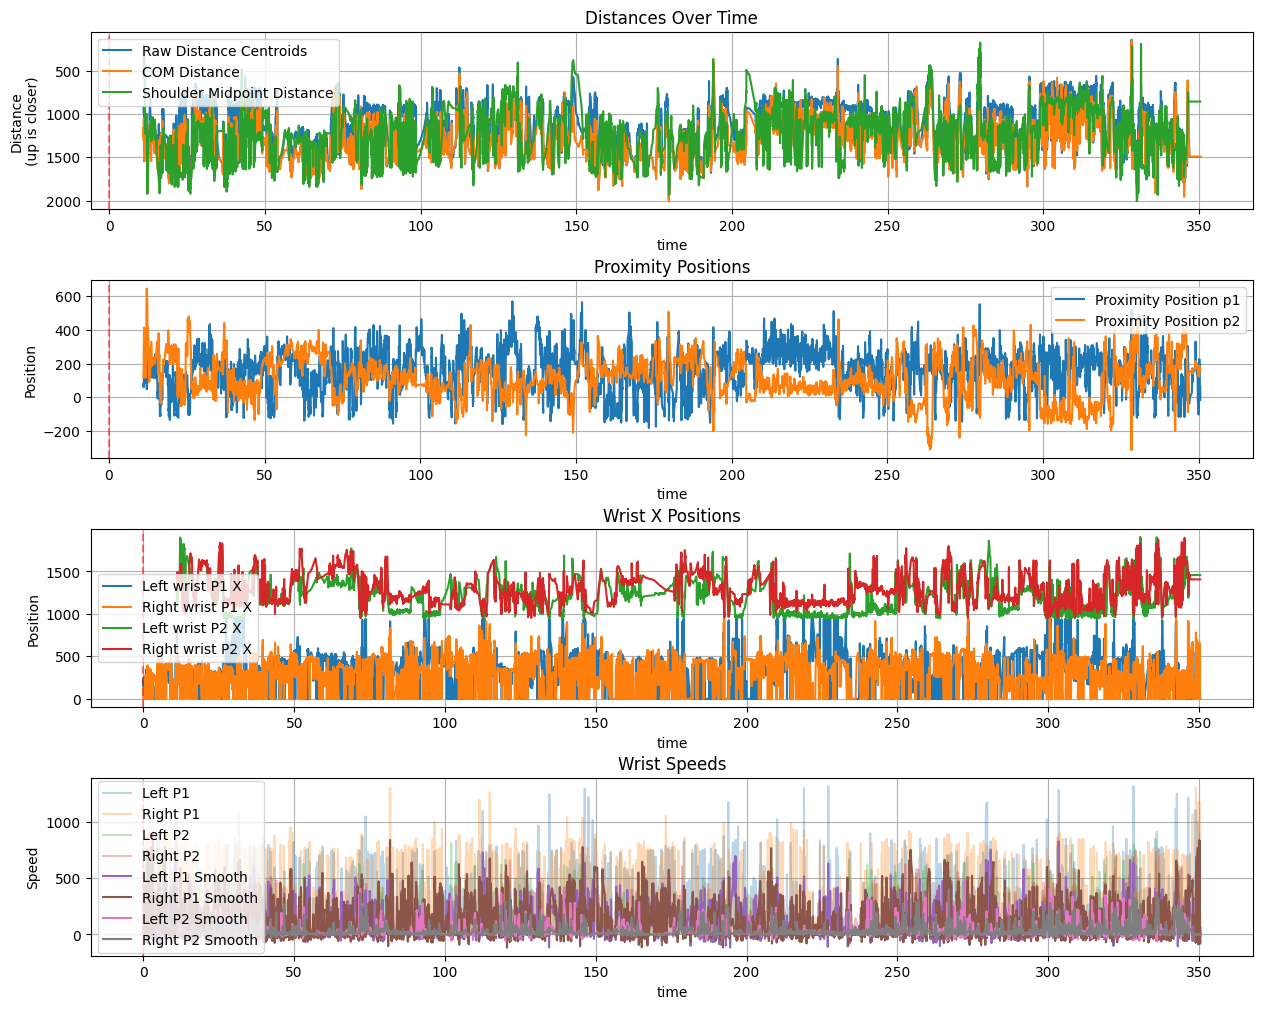

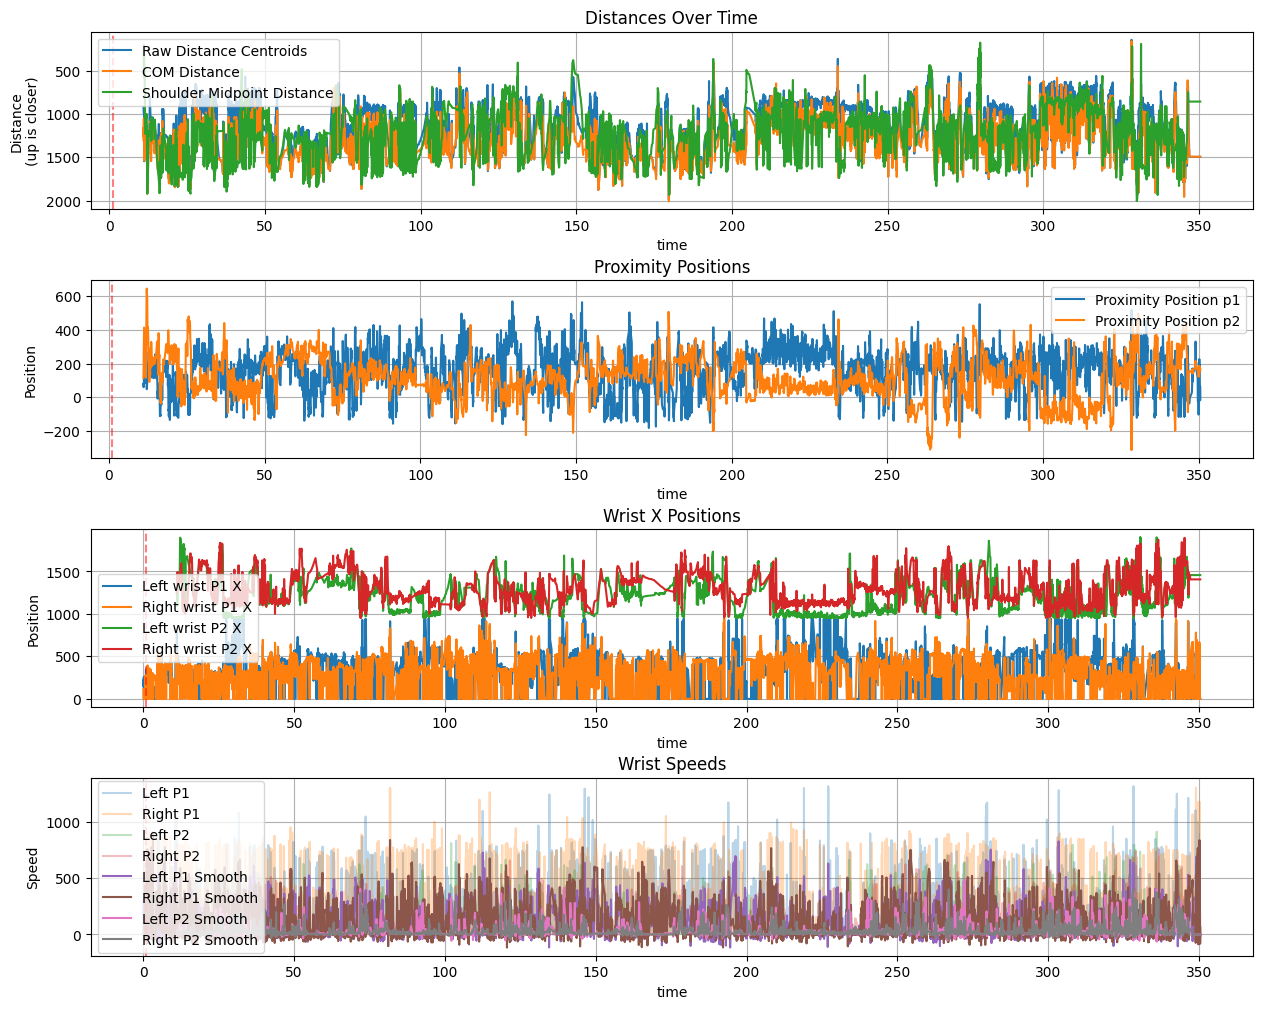

Error in callback <function flush_figures at 0x000001AD18C65620> (for post_execute), with arguments args (),kwargs {}:


: 

: 

In [19]:
import tqdm
import tempfile
import cv2
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

#check all videos with layer 1
inputfol = '../data_sampledatatracked_afterSTEP1/'
inputfol2 = '../data_sampledatatotimeseries_afterSTEP2/'
outputfol = '../animations/'
allvidsnew = glob.glob(inputfol + '*_layer1.mp4')
tempfol = '../temp/'

# make an annimation
for vids in allvidsnew:
     vidname = os.path.basename(vids)
     # remove substring "_annotated_layer1"
     lab = "_annotated_layer1"
     vidname = vidname.replace(lab, "")     
     vidname = vidname[:-4]
          # Load the CSV file
     timeseries_data = pd.read_csv(inputfol2 + '/' + vidname + '_processed_data_layer2.csv')
     # if already exists, skip
     if os.path.exists(outputfol + '/' + vidname + '_distance_layer2.mp4'):
          print("Already processed, skipping...")
     # load the video file in opencv
     cap = cv2.VideoCapture(vids)
     # Get video properties
     fps = int(cap.get(cv2.CAP_PROP_FPS))
     width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
     height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
     # Define the output video writer
     output_path = inputfol2  + '/' + vidname + '_distance_layer2.mp4'
     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
     out = cv2.VideoWriter(outputfol, fourcc, fps, (width, height))
     # loop over the times with tqdm processbar
     time_count = 0
     for _ in tqdm.tqdm(range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))):
          # read the time
          success, time = cap.read()
          if not success:
                break
          # plot the distance
          plot = plot_timeseries(timeseries_data, time_count)
          # save the plot to a temp file in the output folder
          with tempfile.NamedTemporaryFile(suffix='.png', delete=False, dir=tempfol) as f:          
                plot.savefig(f.name)
                slice_start = 2 * (height // 3)
                slice_height = time.shape[0] - slice_start
                plot_img = cv2.imread(f.name)
                # Resize dynamically
                plot_img = cv2.resize(plot_img, (width, slice_height))
                # Assign without shape mismatch
                time[slice_start:slice_start + slice_height, :, :] = plot_img
                # write the time to the output video
                # downsize the video by a half
                out.write(time)
                      
          time_count += 1
     # Release everything
     cap.release()
     out.release()
     print(f"Output video saved as {output_path}")
     # delete all temp files
     for file in glob.glob(outputfol + '/*.png'):
          os.remove(file)